[View in Colaboratory](https://colab.research.google.com/github/glasslion/TensorFlow-Tutorials/blob/master/03B_Layers_API_Exercise.ipynb)

In [0]:
%%capture
import os
work_dir = "/content/TensorFlow-Tutorials/"
if os.getcwd() != work_dir:
    !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials.git
os.chdir(work_dir)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import math
import tqdm

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [0]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

## Plot images to see if lables are correct

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

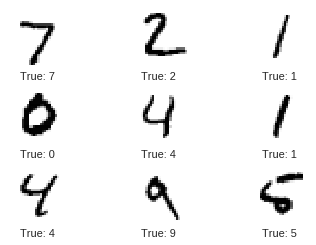

In [7]:
# Get the first images from the test-set.
images = data.test.images[0:9]

data.test.cls = np.argmax(data.test.labels, axis=1)
# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## 模型定义

In [0]:
tf.reset_default_graph()

In [0]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
is_training = tf.placeholder_with_default(True, shape=())

lr=1e-4
global_step = tf.Variable(0)
first_decay_steps = tf.placeholder(tf.int32, name ='first_decay_steps')
lr_decayed = tf.train.cosine_decay_restarts(lr, global_step,
                                   first_decay_steps)


In [0]:
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
    y_true_cls = tf.argmax(y_true, axis=1)
    
    net = x_image
    net = tf.layers.conv2d(inputs=net, name='layer_conv1', padding='same', filters=16, kernel_size=5, activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)
    net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same', filters=36, kernel_size=5, activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)
    net = tf.layers.flatten(net)
    net = tf.layers.dense(inputs=net, name='layer_fc1', units=18, activation=tf.nn.relu)
    net = tf.layers.dropout(inputs=net, name='layer_dropout1', rate=0.5, training=is_training)
    net = tf.layers.dense(inputs=net, name='layer_fc_out', units=num_classes, activation=None)
    logits = net
    y_pred = tf.nn.softmax(logits)
    
    

### Loss & Optimizer

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### Accuracy

In [0]:
y_pred_cls = tf.argmax(y_pred, axis=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [15]:
for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    print(var)

<tf.Variable 'Variable:0' shape=() dtype=int32_ref>
<tf.Variable 'layer_conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv2/kernel:0' shape=(5, 5, 16, 36) dtype=float32_ref>
<tf.Variable 'layer_conv2/bias:0' shape=(36,) dtype=float32_ref>
<tf.Variable 'layer_fc1/kernel:0' shape=(1764, 18) dtype=float32_ref>
<tf.Variable 'layer_fc1/bias:0' shape=(18,) dtype=float32_ref>
<tf.Variable 'layer_fc_out/kernel:0' shape=(18, 10) dtype=float32_ref>
<tf.Variable 'layer_fc_out/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'layer_conv1/kernel/Adam:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/kernel/Adam_1:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias/Adam:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias/Adam_1:0' shape=(16,

## 获取网络层的权重
这里用到的 API 着实诡异， tf 应该提供个更方便的接口

参考:

[How to get weights in tf.layers.dense?](https://stackoverflow.com/questions/45372291/how-to-get-weights-in-tf-layers-dense/45372632)

In [0]:
def get_weights_variable(layer_name):
    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')
      
    return variable   

In [0]:
def get_layer_tensor(layer_name):
    return tf.get_default_graph().get_tensor_by_name(layer_name)

## 模型训练

In [0]:
train = data.train
valid = data.test
epochs = 1
batch_size = 32

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
def fit(epochs, train, valid, batch_size=32):
    for epoch in range(epochs):
        steps_per_epoch = math.ceil(train.num_examples/batch_size)
        pbar = tqdm.trange(steps_per_epoch, disable=True)
        for step in pbar:
            x_batch, y_batch = train.next_batch(batch_size)
            train_feed = {
                x: x_batch,
                y_true: y_batch,
                first_decay_steps: steps_per_epoch,
            }
            sess.run(optimizer, feed_dict=train_feed)
            train_acc, train_loss = sess.run([accuracy, loss], feed_dict=train_feed)
            pbar.set_description('train accu： {:.6f}    train loss {:.6f}'.format(train_acc, train_loss))

        # Caluate validation
        val_acc = 0
        val_loss = 0
        valid_steps_per_epoch = math.ceil(valid.num_examples/batch_size)
        for step in range(valid_steps_per_epoch):
            val_x_batch, val_y_batch = valid.next_batch(batch_size)
            valid_feed = {
                x: val_x_batch,
                y_true: val_y_batch,
            }
            va, vl = sess.run([accuracy, loss], feed_dict=train_feed)
            val_acc += va / valid_steps_per_epoch
            val_loss += vl / valid_steps_per_epoch
        print('valid accu： {:.6f}    valid loss {:.6f}'.format(val_acc, val_loss))

In [32]:
train.num_examples/batch_size

1718.75

In [29]:
fit(15, data.train, data.validation)

valid accu： 0.896298    valid loss 0.267174
valid accu： 0.865048    valid loss 0.304304
valid accu： 0.852508    valid loss 0.346334
valid accu： 0.856290    valid loss 0.317162
valid accu： 0.880772    valid loss 0.279434
valid accu： 0.878384    valid loss 0.267273
valid accu： 0.872014    valid loss 0.295991
valid accu： 0.886943    valid loss 0.270639
valid accu： 0.896696    valid loss 0.255218
valid accu： 0.909236    valid loss 0.234636
valid accu： 0.887142    valid loss 0.284842
valid accu： 0.890725    valid loss 0.270851
valid accu： 0.865247    valid loss 0.326785
valid accu： 0.888137    valid loss 0.275425
valid accu： 0.894705    valid loss 0.272526


In [138]:
fit(1, data.train, data.validation)

valid accu： 0.968750    valid loss 0.039196


## Predict

In [0]:
def predict(dataset, batch_size=32):

    pred = np.zeros((dataset.num_examples, num_classes))
    for offset in range(0, dataset.num_examples, batch_size):
        x_batch, y_batch = dataset.images[offset:offset + batch_size], dataset.labels[offset:offset + batch_size]
        test_feed = {
            x: x_batch,
            y_true: y_batch,
            is_training: False,
        }
        pred_batch = sess.run(y_pred, test_feed)
        pred[offset:offset+len(pred_batch)] = pred_batch
    return pred

In [0]:
pred = predict(data.test, batch_size=32)

In [0]:
def show_accuracy(pred, true):
    pred_cls = np.argmax(pred, axis=1)
    true_cls  = np.argmax(true, axis=1)
    
    return np.count_nonzero(pred_cls==true_cls) / len(pred_cls)
    

In [37]:
show_accuracy(pred, data.test.labels)


0.9869

In [0]:
def show_incorrect_images(pred, test):
    pred_cls = np.argmax(pred, axis=1)
    true_cls  = np.argmax(test.labels, axis=1)
    incorrect = np.where(pred_cls!=true_cls)[0]
    incorrect = np.random.choice(incorrect, 9)
    plot_images(test.images[incorrect], true_cls[incorrect], pred_cls[incorrect])
    

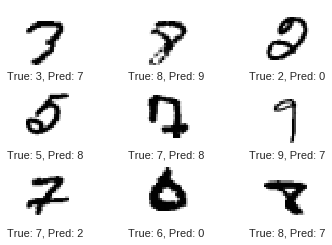

In [39]:
show_incorrect_images(pred, data.test)

In [0]:
def show_confusion_matrix(pred, true):
    pred_cls = np.argmax(pred, axis=1)
    true_cls  = np.argmax(true, axis=1)
    cm = confusion_matrix(true_cls, pred_cls)
    plt.matshow(cm, cmap=plt.cm.GnBu)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.colorbar()
    plt.show()


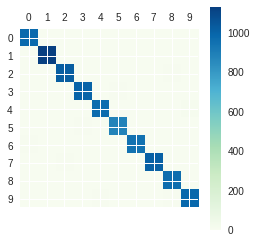

In [41]:
show_confusion_matrix(pred, data.test.labels)


## Visualie model layer weights & filters

In [0]:
def plot_conv_weights(layer_name, input_channel=0):
    weights = get_weights_variable(layer_name)
    w = sess.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i >= num_filters:
            break
        img = w[:,:, input_channel, i]
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
        

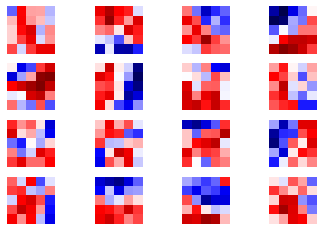

In [143]:
plot_conv_weights('layer_conv1')


In [0]:
image1 = data.test.images[0]

In [0]:
def plot_conv_output(layer_name, image):
    layer = get_layer_tensor(layer_name+':0')
    feed_dict= {x: [image]}
    output = sess.run(layer, feed_dict=feed_dict)
    num_filters = output.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i >= num_filters:
            break
        img = output[0, :, :, i]
        ax.imshow(img, interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
        

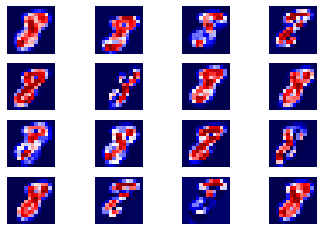

In [146]:
rand_img = data.test.images[np.random.randint(0, len(data.test.images))]
plot_conv_output('max_pooling2d/MaxPool', image=rand_img)

In [141]:
# List all tensors
tf.get_default_graph().get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Reshape/shape' type=Const>,
 <tf.Operation 'Reshape' type=Reshape>,
 <tf.Operation 'y_true' type=Placeholder>,
 <tf.Operation 'ArgMax/dimension' type=Const>,
 <tf.Operation 'ArgMax' type=ArgMax>,
 <tf.Operation 'layer_conv1/kernel/Initializer/random_uniform/shape' type=Const>,
 <tf.Operation 'layer_conv1/kernel/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'layer_conv1/kernel/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'layer_conv1/kernel/Initializer/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'layer_conv1/kernel/Initializer/random_uniform/sub' type=Sub>,
 <tf.Operation 'layer_conv1/kernel/Initializer/random_uniform/mul' type=Mul>,
 <tf.Operation 'layer_conv1/kernel/Initializer/random_uniform' type=Add>,
 <tf.Operation 'layer_conv1/kernel' type=VariableV2>,
 <tf.Operation 'layer_conv1/kernel/Assign' type=Assign>,
 <tf.Operation 'layer_conv1/kernel/read' type=Identity>,
 <tf.Operati